Goal - convenience functions to parse HA data into useful format for data science. Consider creating a class to hold the data.
SQLAlchemy is used in this notebook but other suitable libraries are available.

* http://www.sqlalchemy.org/
* https://facebook.github.io/prophet/

Using Google cloud data

In [1]:
%matplotlib inline
from datetime import datetime
from sqlalchemy import create_engine, text
import json
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from fbprophet import Prophet

In [2]:
def load_url(filename):
    """Convenience for loading a url from a json file."""
    try:
        with open(filename, 'r') as fp:
            url = json.load(fp)
    except Exception as e:
        print('Failed to load url')
        url = None
    return url['url']

Some helper functions for parsing HA data

In [3]:
def time_category(dtObj):
    """Return a time category, bed, home, work, given a datetime object dtObj."""
    if 9 <= dtObj.hour <= 17:
        return 'daytime'
    elif 5 <= dtObj.hour < 9:
        return 'morning'
    elif 17 < dtObj.hour < 23:
        return 'evening'
    else:
        return 'night'

In [4]:
def is_weekday(dtObj):
    """Check a datetime object dtObj is a weekday"""
    if dtObj.weekday() < 5:
        return True
    else:
        return False

In [5]:
def isfloat(value):
    """Check if string can be parsed to a float."""
    try:
        float(value)
        return True
    except ValueError:
        return False

isfloat('23.6')

True

In [6]:
def parse_state(value):
    """Check if state can be parsed to a float."""
    try:
        float(value)
        return float(value)
    except ValueError:
        return value

val = parse_state('23.6')

In [7]:
parse_state('foo')

'foo'

In [8]:
def binary_state(value):
    """Return a binary for the state of binary sensors"""
    if  value == 'on':
        return True
    elif value == 'off':
        return False
    else:
        return float('nan')

print(binary_state('on'))
print(binary_state('off'))
print(binary_state('foo'))

True
False
nan


In [9]:
def rename_entity(entity_id):
    """Takes an entity_if of form sensor.name and returns name."""
    return entity_id.split('.')[1]

rename_entity('sensor.bme680humidity')

'bme680humidity'

Conveninece to query and filter list of entities

In [10]:
def query_entities(*args, **kwargs):
    """Takes a query term or terms and returns a list of entities satisfying the term. 
    Additionally apply a single filter term. 
    Example usage = query_entities('temperature', 'light', filter='sensor)"""
    query_results = [entity for entity in entity_list if any(query in entity for query in args)] 
    if kwargs['filter']:
        filtered_resaults = [entity for entity in query_results if kwargs['filter'] in entity]
        return filtered_resaults
    else:
        return query_results

Convenience function for checking a state. This is incredibly slow when applied to large data frames. Better approach is place data on time index and fill.

In [11]:
def state_at_time(df, dtObj):
    """Check the last registered state at some time using asof.
    Passed df needs to be time indexed and should only include the entitiy_id of interest."""
    found_index = df.index.asof(dtObj)     # Find the closest index asof time test_time
    if pd.isnull(found_index):             # If dtObj is before the first index of dt, will return NaT
        return float('nan')
    else:
        state = df.loc[found_index]['state']      # Get the state at the found_index
        return state

## Fetch the states data

In [12]:
filename = '/Users/robincole/Desktop/hass_db_url.json'
DB_URL = load_url(filename)

In [13]:
engine = create_engine(DB_URL)

Lets query all the data and put it in a dataframe

In [18]:
%%time
stmt = text(
"""
SELECT domain, entity_id, state, last_changed 
FROM states 
WHERE NOT state='unknown' 
""")

allquery = engine.execute(stmt)
# get rows from query into a pandas dataframe
allqueryDF = pd.DataFrame(allquery.fetchall())
master_df = allqueryDF.copy()

CPU times: user 4.49 s, sys: 1.07 s, total: 5.56 s
Wall time: 46.1 s


In [33]:
master_df.shape

(758927, 4)

In [34]:
print("The dataframse size on disk is {} MB".format(master_df.values.nbytes/1e6))

The dataframse size on disk is 24.285664 MB


Name the columns, need to look into the difference between last_changed & last_updated

In [35]:
master_df.columns = ['domain', 'entity', 'state', 'last_changed']

In [36]:
master_df.head()

,domain,entity,state,last_changed
0,sensor,sensor.bme680humidity,61.093,2017-12-28 12:36:02.118528+00:00
1,sensor,sensor.living_room_motion_sensor,off,2017-12-28 12:36:15.183410+00:00
2,sensor,sensor.bme680humidity,61.028,2017-12-28 12:36:17.334867+00:00
3,sun,sun.sun,above_horizon,2017-12-28 08:05:59.158553+00:00
4,sensor,sensor.living_room_motion_sensor,off,2017-12-28 12:36:15.183410+00:00


In [37]:
master_df.iloc[0]['last_changed']

Timestamp('2017-12-28 12:36:02.118528+0000', tz='psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)')

Lets drop the timezone and work with naive timestamps

In [38]:
master_df['last_changed'] = master_df['last_changed'].apply(lambda x: x.tz_localize(None))

Lets create a column that indicates if a state is numerical data

In [39]:
master_df['numerical'] = master_df['state'].apply(lambda x: isfloat(x)) 

Convert to multi-index to allow easy querying

In [40]:
master_df.set_index(['domain', 'entity', 'numerical', 'last_changed'], inplace=True)
master_df.head()

state
domain entity                           numerical last_changed                             
sensor sensor.bme680humidity            True      2017-12-28 12:36:02.118528         61.093
       sensor.living_room_motion_sensor False     2017-12-28 12:36:15.183410            off
       sensor.bme680humidity            True      2017-12-28 12:36:17.334867         61.028
sun    sun.sun                          False     2017-12-28 08:05:59.158553  above_horizon
sensor sensor.living_room_motion_sensor False     2017-12-28 12:36:15.183410            off

## Numerical data
lets do a query for numerical sensor

In [46]:
sensors_num_df = master_df.query('domain == "sensor" & numerical == True')
sensors_num_df['state'] = sensors_num_df['state'].astype('float')
sensors_num_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


state
domain entity                numerical last_changed                        
sensor sensor.bme680humidity True      2017-12-28 12:36:02.118528    61.093
                                       2017-12-28 12:36:17.334867    61.028
       sensor.bme680pressure True      2017-12-28 12:36:42.732863  1001.880
                                       2017-12-28 12:36:52.873211  1001.890
       sensor.next_train_in  True      2017-12-28 12:37:03.724140     7.000

In [47]:
num_sensors_list = list(sensors_num_df.index.get_level_values('entity').unique())
print(len(num_sensors_list))
num_sensors_list

28


['sensor.bme680humidity',
 'sensor.bme680pressure',
 'sensor.next_train_in',
 'sensor.living_room_temperature',
 'sensor.darksky_sensor_temperature',
 'sensor.mean_temperature',
 'sensor.bme680temperature',
 'sensor.bedroom_temperature',
 'sensor.next_train_to_wim',
 'sensor.network_up',
 'sensor.home_to_waterloo',
 'sensor.memory_usage_real',
 'sensor.cpu_load_total',
 'sensor.speedtest_download',
 'sensor.home_to_work',
 'sensor.work_to_home',
 'sensor.bayes_probability',
 'sensor.hall_temperature',
 'sensor.bme680air_qual',
 'sensor.darksky_sensor_precip_probability',
 'sensor.iphone_battery_level',
 'sensor.robins_iphone_battery_level',
 'sensor.electric_charger_distance',
 'sensor.blink_blink_camera_percy_temperature',
 'sensor.blink_blink_camera_percy_notifications',
 'sensor.volume_used_volume_1',
 'sensor.time_in_bed',
 'sensor.homeassistant_v2db']

Lets do a pivot to get sensors in columns to make plotting convenient. Lets also forward fill the data

In [48]:
sensors_num_df = sensors_num_df.pivot_table(index='last_changed', columns='entity', values='state')
sensors_num_df = sensors_num_df.fillna(method='ffill')
sensors_num_df = sensors_num_df.dropna() # drop any remaining nan
sensors_num_df.index = pd.to_datetime(sensors_num_df.index)

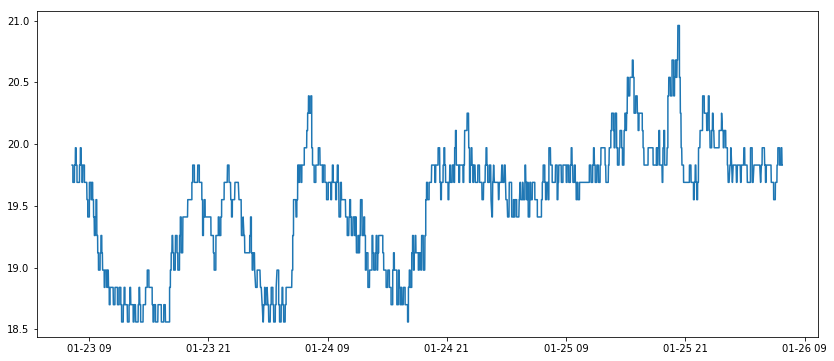

In [49]:
height=6
width=14
figsize=(width, height)

df_plot = sensors_num_df['sensor.living_room_temperature']
last_time = df_plot.index[-1]
hours_to_plot = 24
xfmt = mdates.DateFormatter('%m/%d') # %m-

f, ax = plt.subplots(1, 1, figsize=(width, height))
ax.plot(df_plot)
#ax.xaxis.set_major_formatter(xfmt)
#ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now);

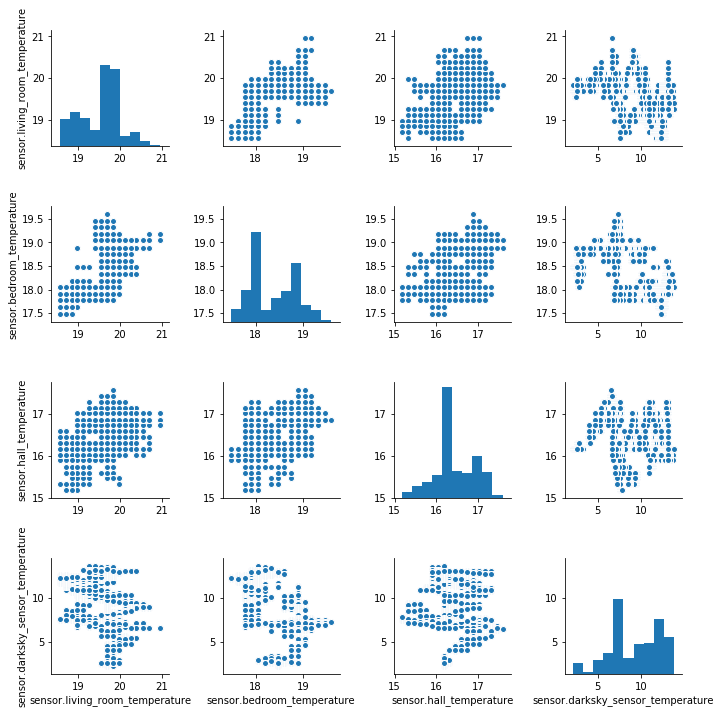

In [50]:
sns_plot = sns.pairplot(
    sensors_num_df[['sensor.living_room_temperature',
                    'sensor.bedroom_temperature',
                    'sensor.hall_temperature', 
                    'sensor.darksky_sensor_temperature']]);

sns_plot.savefig("pairplot.png")

## Single temperature sensor

In [51]:
stmt = text("""
SELECT last_changed, state 
FROM states 
WHERE NOT state='unknown' 
AND states.entity_id = 'sensor.darksky_sensor_temperature'
""")

query = engine.execute(stmt)

# get rows from query into a pandas dataframe
darksky_sensor_temperature = pd.DataFrame(query.fetchall())

In [52]:
darksky_sensor_temperature.head()

,0,1
0,2017-12-25 07:30:07.679411+00:00,9.5
1,2017-12-25 08:33:56.909285+00:00,9.3
2,2017-12-25 09:15:07.994419+00:00,9.4
3,2017-12-25 09:27:30.920648+00:00,9.5
4,2017-12-25 09:33:42.997302+00:00,9.3


In [53]:
darksky_sensor_temperature.iloc[0][0]

Timestamp('2017-12-25 07:30:07.679411+0000', tz='psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)')

In [54]:
darksky_sensor_temperature[0] = darksky_sensor_temperature[0].apply(lambda x: x.tz_localize(None))

In [55]:
darksky_sensor_temperature.iloc[0][0]

Timestamp('2017-12-25 07:30:07.679411')

In [56]:
darksky_sensor_temperature.columns = ['last_changed', 'state']
darksky_sensor_temperature['last_changed']= pd.to_datetime(darksky_sensor_temperature['last_changed'], utc=True)
darksky_sensor_temperature['state'] = darksky_sensor_temperature['state'].astype('float')
darksky_sensor_temperature.head()

,last_changed,state
0,2017-12-25 07:30:07.679411+00:00,9.5
1,2017-12-25 08:33:56.909285+00:00,9.3
2,2017-12-25 09:15:07.994419+00:00,9.4
3,2017-12-25 09:27:30.920648+00:00,9.5
4,2017-12-25 09:33:42.997302+00:00,9.3


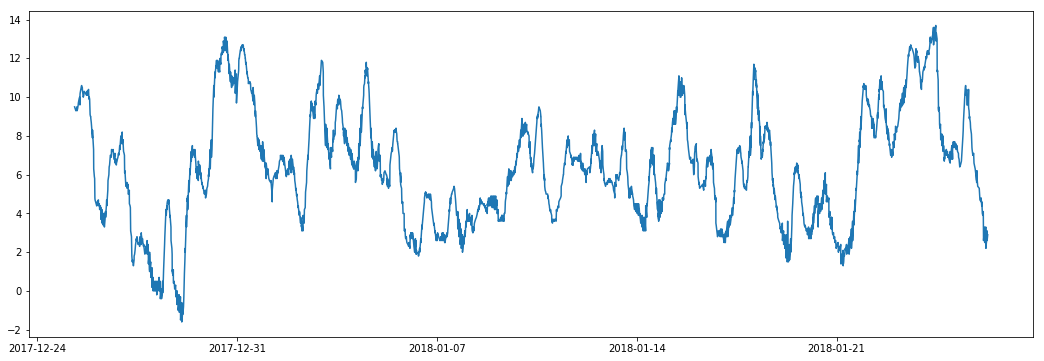

In [57]:
height=6
width=18
figsize=(width, height)

f, ax = plt.subplots(1, 1, figsize=(width, height))
ax.plot(darksky_sensor_temperature['last_changed'], darksky_sensor_temperature['state'])

## Prophet
Lets try some prediction with prophet

In [58]:
df = darksky_sensor_temperature.copy()

In [59]:
df.columns = ['ds', 'y']

In [60]:
df.iloc[0]['ds']

Timestamp('2017-12-25 07:30:07.679411+0000', tz='UTC')

In [61]:
df['ds'] = df['ds'].apply(lambda x: x.tz_localize(None))

In [62]:
df.iloc[0]['ds']

Timestamp('2017-12-25 07:30:07.679411')

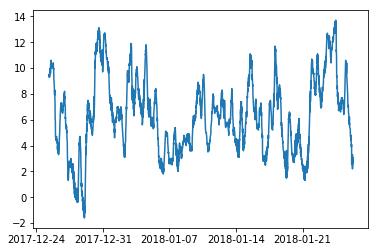

In [63]:
plt.plot(df['ds'], df['y'])

In [64]:
% time
m = Prophet()
m.fit(df);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [65]:
future = m.make_future_dataframe(periods=365, freq='H')

In [66]:
future.head()

,ds
0,2017-12-25 07:30:07.679411
1,2017-12-25 08:33:56.909285
2,2017-12-25 09:15:07.994419
3,2017-12-25 09:27:30.920648
4,2017-12-25 09:33:42.997302


In [67]:
future.iloc[0]['ds'] # Daily forecasts

Timestamp('2017-12-25 07:30:07.679411')

In [68]:
forecast = m.predict(future)

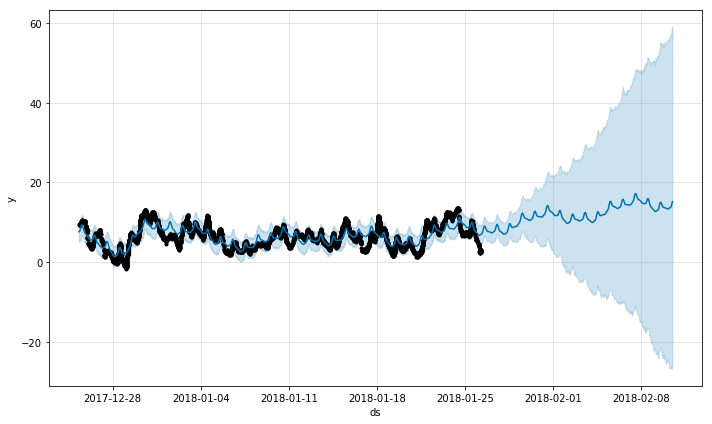

In [69]:
m.plot(forecast);

In [70]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
0,2017-12-25 07:30:07.679411,7.738118,7.738118,7.738118,5.183335,10.076481,-0.463583,-0.463583,-0.463583,-0.106411,-0.106411,-0.106411,-0.106411,-0.106411,-0.106411,0.357172,0.357172,0.357172,7.631708
1,2017-12-25 08:33:56.909285,7.622936,7.622936,7.622936,5.167170,10.224475,-0.367611,-0.367611,-0.367611,0.081948,0.081948,0.081948,0.081948,0.081948,0.081948,0.449559,0.449559,0.449559,7.704884
2,2017-12-25 09:15:07.994419,7.548606,7.548606,7.548606,5.346799,10.274410,-0.224758,-0.224758,-0.224758,0.281020,0.281020,0.281020,0.281020,0.281020,0.281020,0.505778,0.505778,0.505778,7.829626
3,2017-12-25 09:27:30.920648,7.526259,7.526259,7.526259,5.467271,10.312202,-0.164037,-0.164037,-0.164037,0.358095,0.358095,0.358095,0.358095,0.358095,0.358095,0.522132,0.522132,0.522132,7.884355
4,2017-12-25 09:33:42.997302,7.515067,7.515067,7.515067,5.452851,10.312985,-0.130336,-0.130336,-0.130336,0.399890,0.399890,0.399890,0.399890,0.399890,0.399890,0.530226,0.530226,0.530226,7.914957


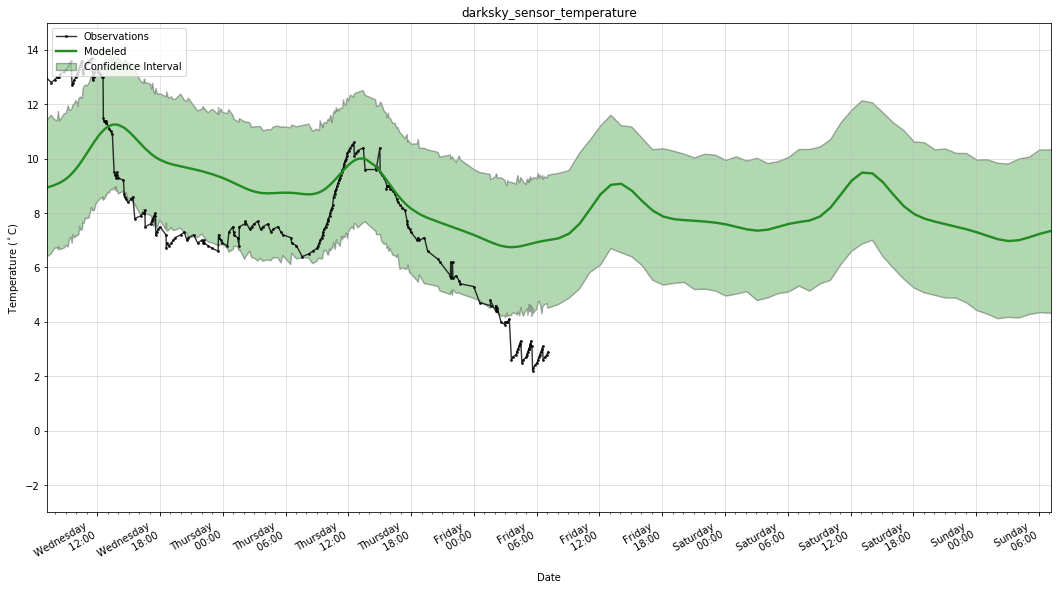

In [72]:
# Steal from Stocker to make a nicer plot
height=10
width=18

now = dt.datetime.now()
hours_to_plot = 24*2

fig, ax = plt.subplots(1, 1, figsize=(width, height))

ax.plot(df['ds'], df['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
    
ax.plot(forecast['ds'], forecast['yhat'], 'forestgreen',linewidth = 2.4, label = 'Modeled');

# Plot the uncertainty interval as ribbon
ax.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_upper'], forecast['yhat_lower'], alpha = 0.3, 
facecolor = 'g', edgecolor = 'k', linewidth = 1.4, label = 'Confidence Interval')

# Plot formatting
ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now+dt.timedelta(hours=hours_to_plot))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%A \n %H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.set_ylim(-3.0, 15.0)

plt.legend(loc = 2, prop={'size': 10}); plt.xlabel('Date'); plt.ylabel('Temperature ($^\circ$C)');
plt.grid(linewidth=0.6, alpha = 0.6)
title = 'darksky_sensor_temperature'
plt.title(title);
plt.savefig('darksky_sensor_temperature_precition.jpg')
fig.autofmt_xdate()
plt.show()

### Motion at home sensor
Lets focus on the binary_sensor.motion_at_home which is a sensor that indicates if there is any activity at home. In the pivot_table apply np.min to prevent np.mean (the default) from returning 0.5 in some cases (why is this?)

In [73]:
binary_sensors_df = master_df.query('domain == "binary_sensor"')
binary_sensors_list = list(binary_sensors_df.index.get_level_values('entity').unique())
print(len(binary_sensors_list))
binary_sensors_list

13


['binary_sensor.motion_at_home',
 'binary_sensor.in_bed_bayesian',
 'binary_sensor.elgato_door',
 'binary_sensor.late_night_sensor',
 'binary_sensor.devices_home',
 'binary_sensor.wipy_water_monitor',
 'binary_sensor.fibaro_leak',
 'binary_sensor.macbook',
 'binary_sensor.workday_sensor',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.blink_armed_status',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.doorbell']

In [74]:
binary_sensors_df['state'] = binary_sensors_df['state'].apply(lambda x: binary_state(x)) # Binarise

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
binary_sensors_df = binary_sensors_df.pivot_table(index='last_changed', columns='entity', values='state')

In [76]:
binary_sensors_df.head()

entity,binary_sensor.blink_armed_status,binary_sensor.blink_blink_camera_percy_motion_enabled,binary_sensor.devices_home,binary_sensor.doorbell,binary_sensor.elgato_door,binary_sensor.fibaro_leak,binary_sensor.in_bed_bayesian,binary_sensor.late_night_sensor,binary_sensor.living_room_nest_protect_online,binary_sensor.macbook,binary_sensor.motion_at_home,binary_sensor.wipy_water_monitor,binary_sensor.workday_sensor
last_changed,,,,,,,,,,,,,
2017-12-25 07:30:00.472937,None,None,None,None,None,None,None,None,None,None,False,None,None
2017-12-25 07:30:00.474791,None,None,None,None,None,None,None,False,None,None,None,None,None
2017-12-25 07:30:00.476154,None,None,False,None,None,None,None,None,None,None,None,None,None
2017-12-25 07:30:00.477496,None,None,None,None,None,None,False,None,None,None,None,None,None
2017-12-25 07:30:00.728927,None,None,None,None,None,None,None,None,None,None,None,False,None


In [77]:
binary_sensors_df = binary_sensors_df.fillna(method='ffill')
binary_sensors_df = binary_sensors_df.dropna() # drop any remaining nan

Lets get only the motion sensor and put in a dataframe

In [78]:
motion_df = binary_sensors_df["binary_sensor.motion_at_home"].to_frame() 

In [79]:
motion_df.index = pd.to_datetime(motion_df.index)

#### Create some features
Lets get the weekday

In [80]:
motion_df['weekday'] = motion_df.index.weekday_name

In [81]:
motion_df['time'] = motion_df.index.time

In [82]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: is_weekday(x))

In [83]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [84]:
motion_df['time_category'] = motion_df.index.map(lambda x: time_category(x))

In [85]:
motion_df.head()

,binary_sensor.motion_at_home,weekday,time,is_weekday,time_category
last_changed,,,,,
2017-12-29 08:05:52.867213,True,Friday,08:05:52.867213,True,morning
2017-12-29 08:06:11.862516,True,Friday,08:06:11.862516,True,morning
2017-12-29 08:07:09.870728,True,Friday,08:07:09.870728,True,morning
2017-12-29 08:12:12.865352,True,Friday,08:12:12.865352,True,morning
2017-12-29 08:17:49.864774,True,Friday,08:17:49.864774,True,morning


#### Analysis of motion data
Try a facet grid to represent data https://seaborn.pydata.org/generated/seaborn.FacetGrid.html?highlight=facet#seaborn.FacetGrid
Lets see if there is more motion at home on weekends.

In [86]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

is_weekday
False    1975
True     4886
Name: count, dtype: object

OK, so there is more activity at home on weekdays, but there are also 5 days in the working week and 2 in the weekend.

Now, how about activity by weekday.

And activity by weekday and time category.

In [87]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time_category,,,,,,,
daytime,465,146,395,676,116,419,67
evening,325,416,84,228,387,320,449
morning,269,297,259,265,339,391,329
night,28,15,30,38,32,62,14


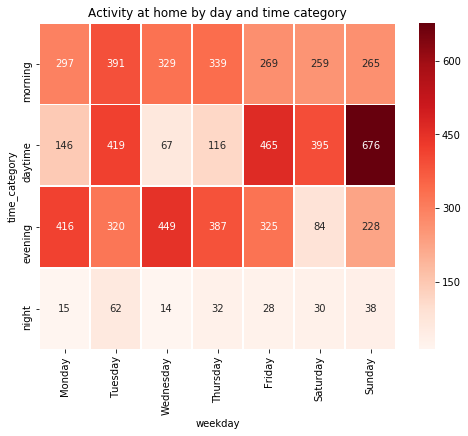

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
fig.savefig('heatmap.jpg')

## Bayesian sensor

In [90]:
query = 'entity == "binary_sensor.in_bed_bayesian"'
in_bed_bayes_df = master_df.query(query)
in_bed_bayes_df.head()

state
domain        entity                        numerical last_changed                    
binary_sensor binary_sensor.in_bed_bayesian False     2017-12-28 06:55:59.210832   off
                                                      2017-12-28 06:55:59.210832   off
                                                      2017-12-28 06:55:59.210832   off
                                                      2017-12-28 06:55:59.210832   off
                                                      2017-12-28 06:55:59.210832   off

In [91]:
in_bed_bayes_df['state'].unique()

array(['off', 'on'], dtype=object)

Hmm where are my on..

In [92]:
in_bed_bayes_df.index = in_bed_bayes_df.index.get_level_values('last_changed')  # Keep only last_changed level

In [93]:
in_bed_bayes_df.index = pd.to_datetime(in_bed_bayes_df.index)  # Convert to datetime

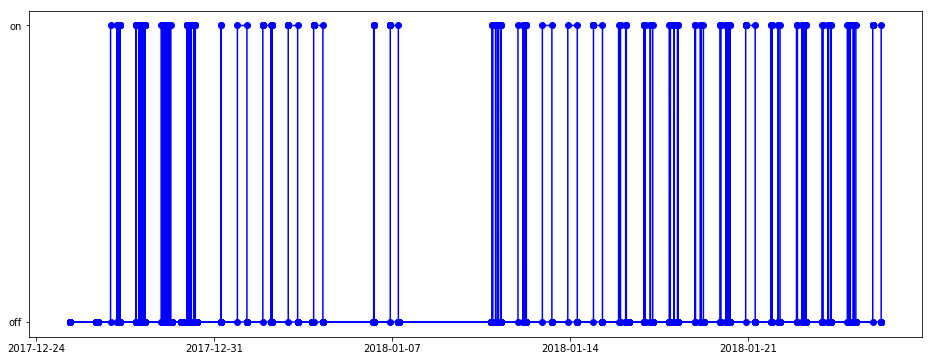

In [94]:
f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')

Text(0,0.5,'In bed status')

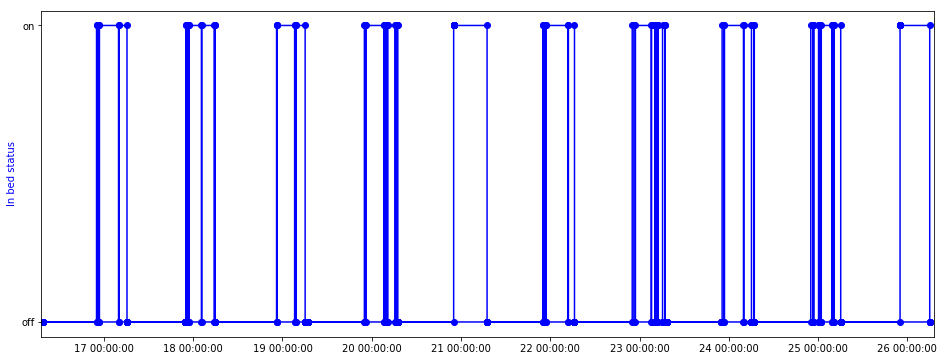

In [96]:
now = dt.datetime.now()
hours_to_plot = 240

f, ax = plt.subplots(figsize=(16, 6))
ax.step(in_bed_bayes_df, 'bo', where='post')
xfmt = mdates.DateFormatter('%d %H:%M:%S') # %m-
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlim(now-dt.timedelta(hours=hours_to_plot), now)
ax.set_ylabel('In bed status', color='b')